In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

In [10]:
from torch.utils.tensorboard import SummaryWriter

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_size = int(0.8 * len(trainset))  # 80% for training
val_size = len(trainset) - train_size  # 20% for validation
torch.manual_seed(123)
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)                                          

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

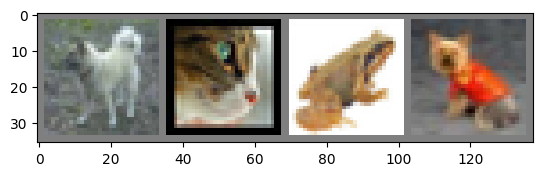

dog   cat   frog  dog  


In [12]:

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def activation(self, x):
        return torch.tanh(x)

    def forward(self, x):
        x = self.pool(self.activation(self.conv1(x)))
        x = self.pool(self.activation(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(128 * 4 * 4, 256)
#         self.fc2 = nn.Linear(256, 10)
#         self.leaky_relu = nn.LeakyReLU(0.01)

#     def forward(self, x):
#         x = self.pool(self.leaky_relu(self.conv1(x)))
#         x = self.pool(self.leaky_relu(self.conv2(x)))
#         x = self.pool(self.leaky_relu(self.conv3(x)))
#         x = x.view(-1, 128 * 4 * 4)
#         x = self.leaky_relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
    
# net = Net()

In [14]:
### Early stopping stuff, from: https://www.geeksforgeeks.org/how-to-handle-overfitting-in-pytorch-models-using-early-stopping/
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)




In [15]:
criterion = nn.CrossEntropyLoss()
optimizer_dict = {
    'SGD, lr=0.001, LeakyReLu': lambda params: optim.SGD(params, lr=0.001),
    'SGD, lr=0.0001, LeakyReLu': lambda params: optim.SGD(params, lr=0.0001),
    'Adam, LeakyReLu': lambda params: optim.Adam(params)
}
#optimizer = optim.SGD(net.parameters(), lr=0.001)

In [16]:
for optimizer_name, optimizer_function in optimizer_dict.items():        

                                                    
    writer = SummaryWriter(f'./diff_optimizers/{optimizer_name}')
    net = Net()
    optimizer = optimizer_function(net.parameters())                        # it is necessary to delay the execution of the optimizer initialisation until here
    early_stopping = EarlyStopping(patience=15, delta=0)

    for epoch in range(200):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics on TRAINING data:
            running_loss += loss.item()
            if i % 2000 == 1999:    
                avg_running_loss = running_loss / 2000
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_running_loss:.3f}')
                writer.add_scalar("Loss/train", avg_running_loss, epoch * len(trainloader) + i)
                #writer.add_scalar("Accuracy/train", (outputs.argmax(1) == labels).float().mean(), epoch * len(trainloader) + i)
                writer.flush()
                running_loss = 0.0

        # Print statistics on VALIDATION data:
        correct = 0
        total = 0
        avg_loss = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                # calculate outputs by running images through the network
                outputs = net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                avg_loss += criterion(outputs, labels)
        avg_loss /= len(valloader)
        writer.add_scalar("Loss/validation", avg_loss, epoch * (len(trainloader) + 1) )
        writer.add_scalar("Accuracy/validation", correct / total, epoch * (len(trainloader) + 1))
        writer.flush()
        early_stopping(avg_loss, net)
        if early_stopping.early_stop:
            print("Early stopping")
            writer.add_scalar("Early stopping after epochs", epoch)
            break

    early_stopping.load_best_model(net)
    ### Test of best model on TEST data:
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            avg_loss += criterion(outputs, labels)
    avg_loss /= len(valloader)
    writer.add_scalar("Loss/test", avg_loss, epoch * (len(trainloader) + 1) )
    writer.add_scalar("Accuracy/test", correct / total, epoch * (len(trainloader) + 1))
    writer.flush()



    writer.close()
    PATH = f'./diff_optimizers/{optimizer_name}.pth'
    torch.save(net.state_dict(), PATH)
    print('Finished Training')


[1,  2000] loss: 2.274
[1,  4000] loss: 2.163
[1,  6000] loss: 2.051
[1,  8000] loss: 1.990
[1, 10000] loss: 1.956
[2,  2000] loss: 1.918
[2,  4000] loss: 1.879
[2,  6000] loss: 1.839
[2,  8000] loss: 1.753
[2, 10000] loss: 1.726
[3,  2000] loss: 1.684
[3,  4000] loss: 1.676
[3,  6000] loss: 1.653
[3,  8000] loss: 1.636
[3, 10000] loss: 1.617
[4,  2000] loss: 1.597
[4,  4000] loss: 1.566
[4,  6000] loss: 1.537
[4,  8000] loss: 1.522
[4, 10000] loss: 1.498
[5,  2000] loss: 1.483
[5,  4000] loss: 1.466
[5,  6000] loss: 1.454
[5,  8000] loss: 1.430
[5, 10000] loss: 1.440
[6,  2000] loss: 1.412
[6,  4000] loss: 1.419
[6,  6000] loss: 1.378
[6,  8000] loss: 1.374
[6, 10000] loss: 1.368
[7,  2000] loss: 1.379
[7,  4000] loss: 1.352
[7,  6000] loss: 1.325
[7,  8000] loss: 1.323
[7, 10000] loss: 1.326
[8,  2000] loss: 1.305
[8,  4000] loss: 1.304
[8,  6000] loss: 1.304
[8,  8000] loss: 1.309
[8, 10000] loss: 1.285
[9,  2000] loss: 1.262
[9,  4000] loss: 1.276
[9,  6000] loss: 1.278
[9,  8000] 

In [17]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

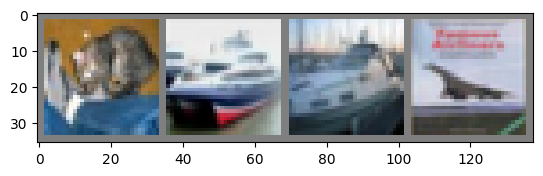

GroundTruth:  cat   ship  ship  plane


In [18]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [19]:
outputs = net(images)

In [20]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


In [21]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 56 %


In [22]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 61.9 %
Accuracy for class: car   is 73.4 %
Accuracy for class: bird  is 48.9 %
Accuracy for class: cat   is 30.7 %
Accuracy for class: deer  is 48.8 %
Accuracy for class: dog   is 42.6 %
Accuracy for class: frog  is 67.9 %
Accuracy for class: horse is 56.5 %
Accuracy for class: ship  is 71.8 %
Accuracy for class: truck is 59.9 %


In [23]:
writer.flush()
writer.close()